In [1]:
%load_ext nb_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use("seaborn")

<IPython.core.display.Javascript object>

### Background

Data source:
https://www.kaggle.com/kyr7plus/emg-4

This data was taken from the Myo armband. An array of 8 Electromyography (EMG) sensors worn around arm. 


<div>
<img src="myo-on-arm-wave.jpg" width="500"/>
</div>

The question is, can we use the data from these sensors to determine the gesture the user is holding their hand in. For this experiment we are trying to recognize these 4 gestures: rock, paper, scsisors like the game and the "okay" hand sign. See the image below for refference.

<div>
<img src="paper-rock-scissors-ok-01.jpg" width="300"/>
</div>

The purpose of this model would be to use it as part of a system to control a prosthetic or robotic arm as seen in the video at the link below.

https://youtu.be/xKUn0-Bhb7U


### Setup dask client

In [2]:
from dask.distributed import Client, progress

client = Client(n_workers=4, threads_per_worker=2, memory_limit="2GB")
client

Client Scheduler: tcp://127.0.0.1:61304 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


<IPython.core.display.Javascript object>

In [3]:
import dask.dataframe as dd
import joblib

<IPython.core.display.Javascript object>

In [4]:
# Each of the gestures is in it's own file lets take a look at what one of them looks like.
test_data = dd.read_csv("gestures/0.csv")
test_data.head()

,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0.3,8.0.1,5.0.1,4.0.4,-7.0.1,-59.0,16.0,0
0,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
1,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
2,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
3,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
4,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,0


<IPython.core.display.Javascript object>

In [5]:
test_data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 65 entries, 26.0 to 0
dtypes: float64(64), int64(1)

<IPython.core.display.Javascript object>

In [6]:
test_data.isnull().sum().max().compute()

0

<IPython.core.display.Javascript object>

In [7]:
# Here we are creating labels for the each of the 64 columns.
# Since there are 8 observations from the 8 sensors in sequence
# we will label the columns as follows observationN_XM with N representing the observation
# number and M representing the sensor number.
features = ["observation" + str(i) + "_X" + str(j) for i in range(8) for j in range(8)]

columns = []
columns += features
# Add a label for the last column. This will be the target for our classifier model
columns.append("target_gesture")
# Set up a test dataFrame with column labels
dd.read_csv("gestures/0.csv", names=columns).head()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7,observation1_X0,observation1_X1,...,observation6_X7,observation7_X0,observation7_X1,observation7_X2,observation7_X3,observation7_X4,observation7_X5,observation7_X6,observation7_X7,target_gesture
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


<IPython.core.display.Javascript object>

In [8]:
# Now we can use the column labels from the above and concatinate the 4 saparate gesture files
# to create a single DataFrame of all our data
gesture_data = dd.read_csv(f"gestures/0.csv", names=columns)
for i in range(1, 4):
    df = dd.read_csv(f"gestures/{i}.csv", names=columns)
    gesture_data = gesture_data.append(df)


<IPython.core.display.Javascript object>

In [9]:
gesture_data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 65 entries, observation0_X0 to target_gesture
dtypes: float64(64), int64(1)

<IPython.core.display.Javascript object>

In [10]:
gesture_data.compute()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7,observation1_X0,observation1_X1,...,observation6_X7,observation7_X0,observation7_X1,observation7_X2,observation7_X3,observation7_X4,observation7_X5,observation7_X6,observation7_X7,target_gesture
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,-3.0,-1.0,-1.0,-1.0,-28.0,20.0,5.0,0.0,-5.0,0.0,...,-3.0,1.0,4.0,3.0,4.0,-51.0,-49.0,5.0,-9.0,3
2918,-13.0,-5.0,-4.0,-3.0,-4.0,-24.0,-10.0,-8.0,20.0,9.0,...,6.0,-3.0,-3.0,-3.0,-5.0,-4.0,-45.0,-12.0,-15.0,3
2919,-1.0,-3.0,-1.0,1.0,30.0,38.0,-1.0,36.0,-10.0,1.0,...,14.0,-8.0,-4.0,-4.0,-4.0,-21.0,-29.0,-5.0,0.0,3
2920,1.0,4.0,4.0,5.0,9.0,-10.0,4.0,1.0,-2.0,-1.0,...,-16.0,-3.0,0.0,-3.0,-5.0,-36.0,-90.0,3.0,5.0,3


<IPython.core.display.Javascript object>

### Data Exploration

In [11]:
# It looks like all our data is correctly formatted with no missing values.
# Lets look at some summary statistics
gesture_data.describe().compute()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7,observation1_X0,observation1_X1,...,observation6_X7,observation7_X0,observation7_X1,observation7_X2,observation7_X3,observation7_X4,observation7_X5,observation7_X6,observation7_X7,target_gesture
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-6.000000,-3.000000,-2.000000,-3.000000,-8.000000,-9.000000,-5.000000,-5.000000,-6.000000,-3.000000,...,-6.000000,-6.000000,-3.000000,-3.000000,-3.000000,-8.000000,-10.000000,-5.000000,-5.000000,1.000000
50%,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,2.000000
75%,10.000000,10.000000,3.000000,5.000000,14.000000,18.000000,24.750000,10.000000,10.000000,10.000000,...,10.000000,9.000000,10.500000,3.000000,5.000000,13.000000,18.000000,20.000000,10.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


<IPython.core.display.Javascript object>

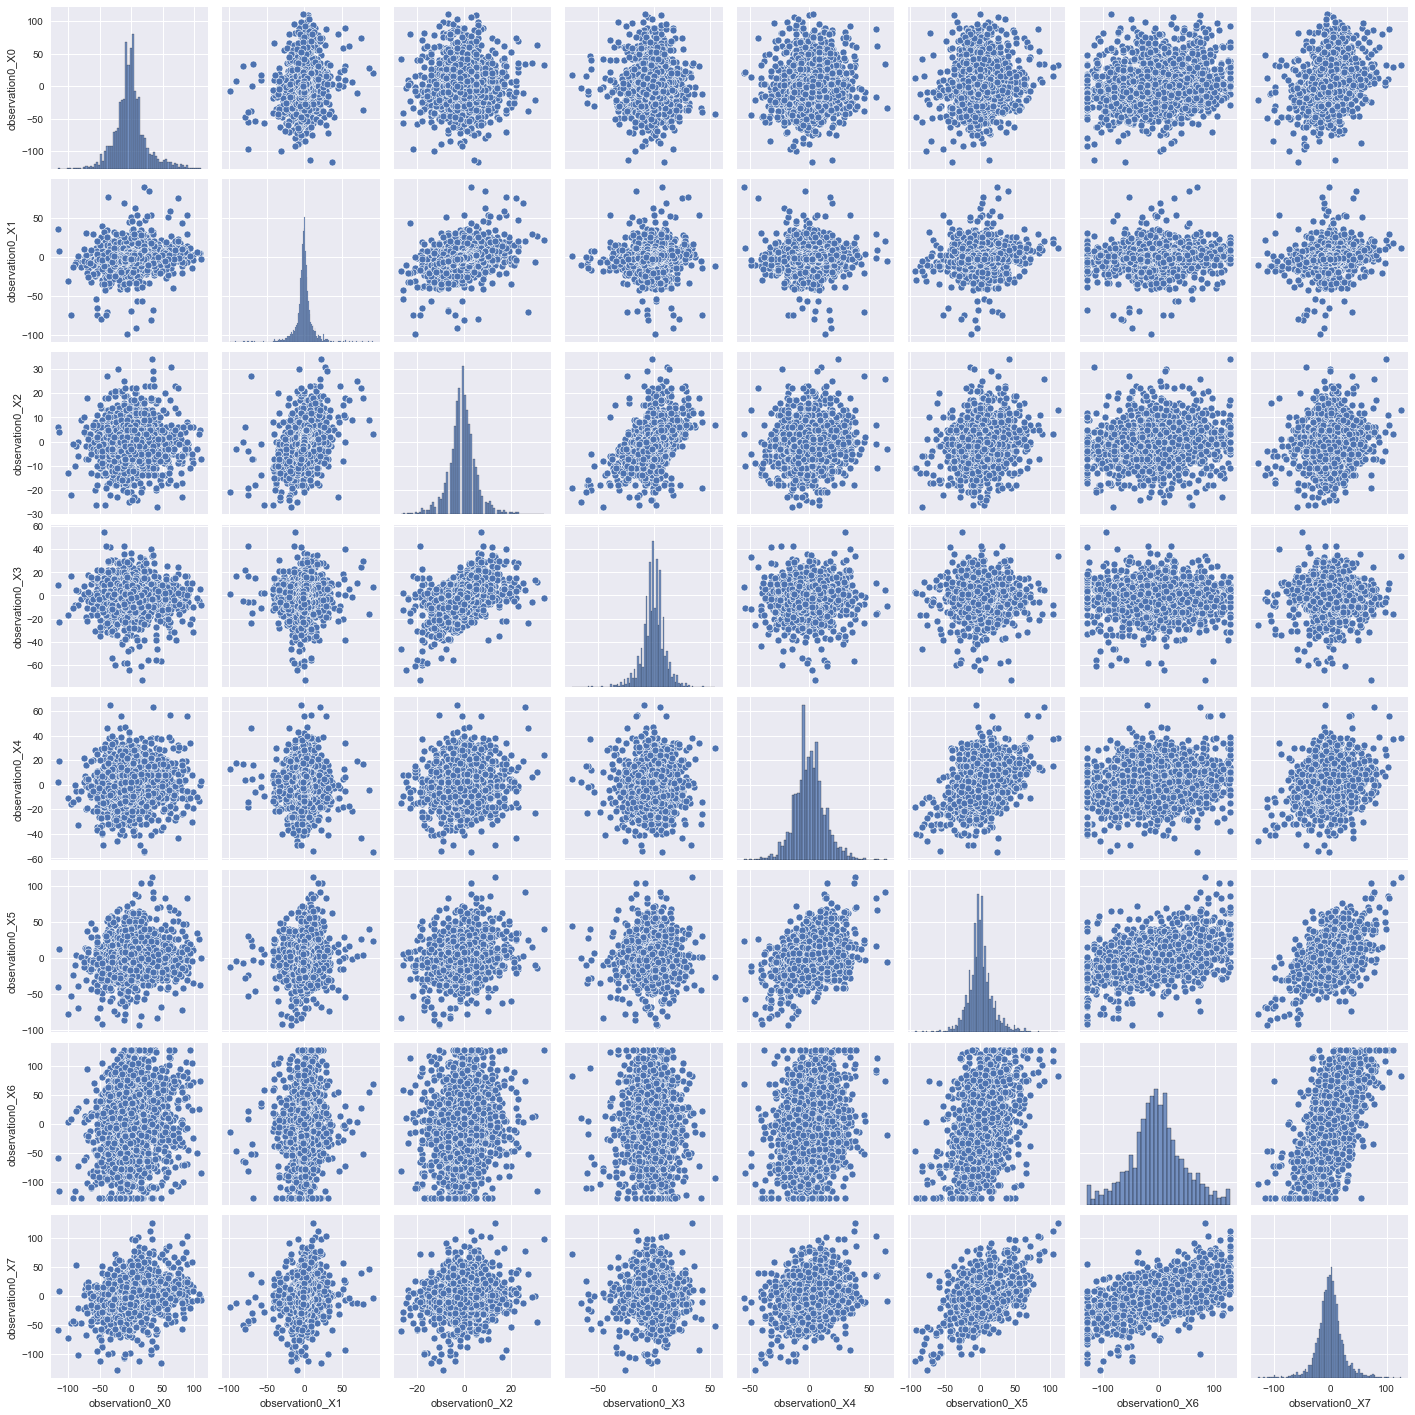

<IPython.core.display.Javascript object>

In [12]:
# Lets look a pair plot to check for correlation between features
sns.pairplot(gesture_data[gesture_data.target_gesture == 0][features[0:8]].compute())
plt.show()

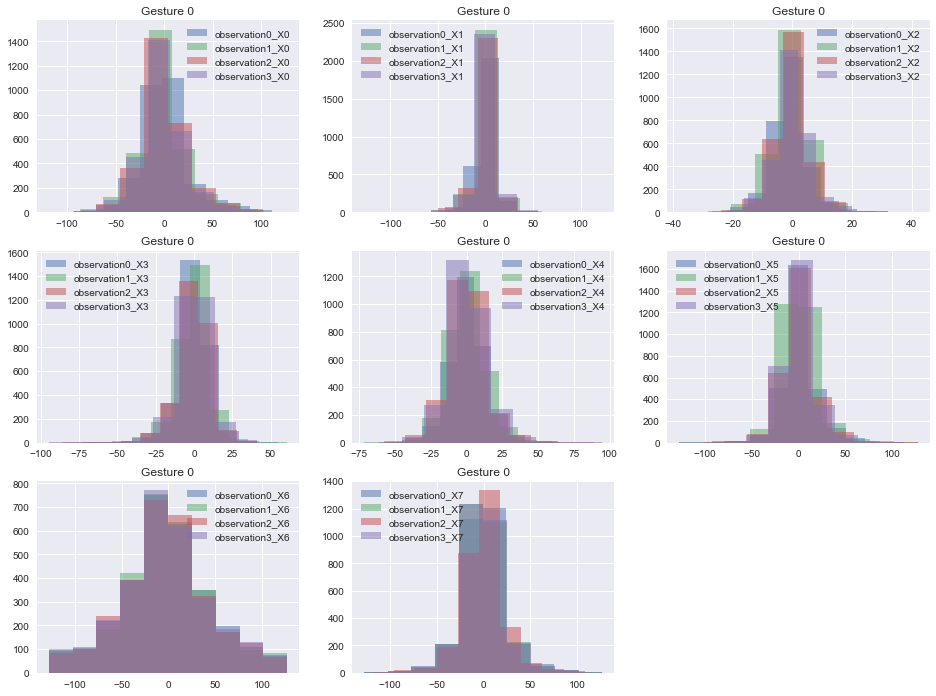

<IPython.core.display.Javascript object>

In [13]:
# In the plots below, I'm looking for variations in the distribution of the different sensors
# For one particular gesture

plt.figure(figsize=(16, 12))
gesture_number = 0
plot_number = 1

for i in range(0, 8):
    legend = []
    plt.subplot(3, 3, plot_number)
    for j in range(0, 32, 8):
        gesture_data[gesture_data.target_gesture == gesture_number][
            features[i + j]
        ].compute().hist(alpha=0.5)
        legend.append(features[i + j])

    plot_number += 1
    plt.legend(legend)
    plt.title(f"Gesture {gesture_number}")


plt.show()

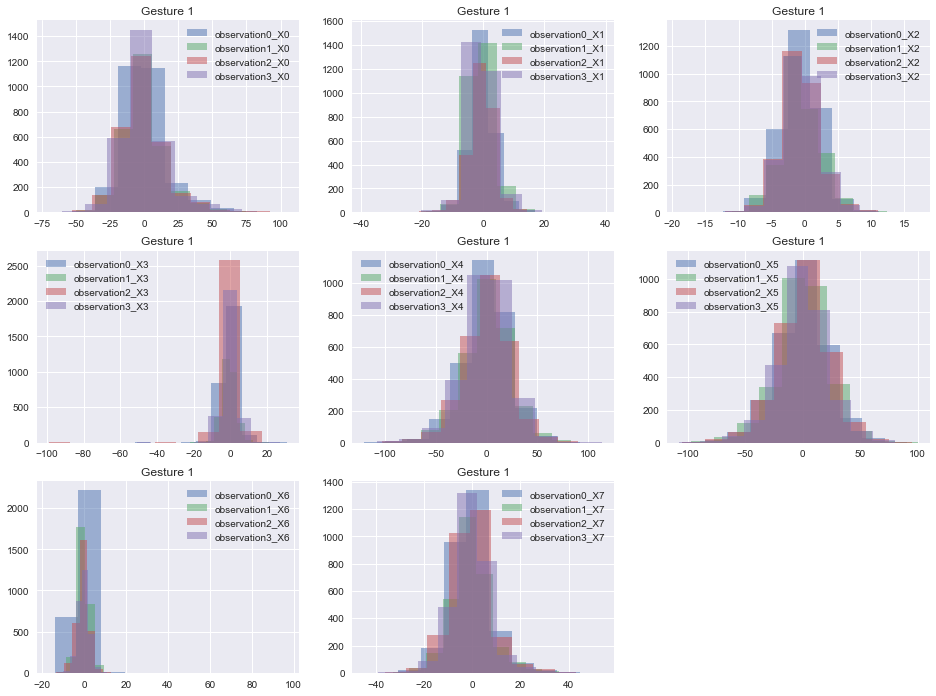

<IPython.core.display.Javascript object>

In [14]:
# Lets look at the same set of distributions for a different gesture

plt.figure(figsize=(16, 12))
gesture_number = 1
plot_number = 1

for i in range(0, 8):
    legend = []
    plt.subplot(3, 3, plot_number)
    for j in range(0, 32, 8):
        gesture_data[gesture_data.target_gesture == gesture_number][
            features[i + j]
        ].compute().hist(alpha=0.5)
        legend.append(features[i + j])

    plot_number += 1
    plt.legend(legend)
    plt.title(f"Gesture {gesture_number}")


plt.show()

In [15]:
# The plots above are noticalbly differnt from the first set so that give me some indication
# that our model could possibly classify the differenet gestures

<IPython.core.display.Javascript object>

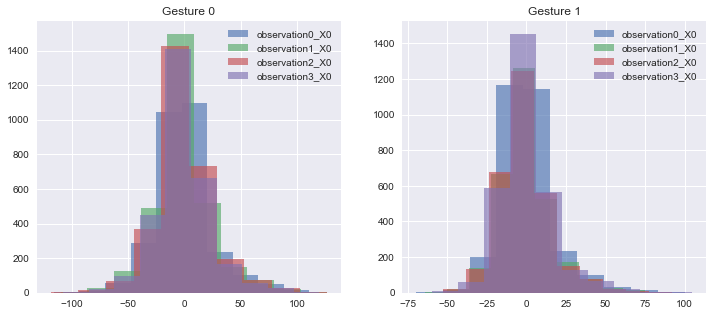

<IPython.core.display.Javascript object>

In [16]:
# lets take a closer look at the distributions from one sensor
def sensor_dist_plot(gesture, sensor):
    legend = []
    obs0 = gesture_data[gesture_data.target_gesture == gesture][
        f"observation0_X{sensor}"
    ].compute()
    obs0.hist(alpha=0.65)
    legend.append(obs0.name)

    obs1 = gesture_data[gesture_data.target_gesture == gesture][
        f"observation1_X{sensor}"
    ].compute()
    obs1.hist(alpha=0.65)
    legend.append(obs1.name)

    obs2 = gesture_data[gesture_data.target_gesture == gesture][
        f"observation2_X{sensor}"
    ].compute()
    obs2.hist(alpha=0.65)
    legend.append(obs2.name)

    obs3 = gesture_data[gesture_data.target_gesture == gesture][
        f"observation3_X{sensor}"
    ].compute()
    obs3.hist(alpha=0.65)
    legend.append(obs3.name)
    plt.legend(legend)
    plt.title(f"Gesture {gesture}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sensor_dist_plot(0, 0)
plt.subplot(1, 2, 2)
sensor_dist_plot(1, 0)
plt.show()

In [17]:
# Looking at more summary statistics for specific gestrues and observation sets
gesture_data[gesture_data.target_gesture == 0][features[0:8]].compute().describe()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7
count,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000
mean,-0.622680,-0.693471,-0.730584,-0.715120,0.076289,0.161856,-2.963230,-0.686598
std,25.581029,11.898513,6.208888,10.840904,12.900192,19.134960,48.548159,23.575177
min,-116.000000,-99.000000,-27.000000,-73.000000,-55.000000,-93.000000,-128.000000,-128.000000
25%,-14.000000,-4.000000,-4.000000,-6.000000,-8.000000,-9.000000,-30.000000,-12.000000
50%,-2.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-4.000000,-1.000000
75%,10.000000,3.000000,2.000000,5.000000,8.000000,8.750000,24.750000,10.000000
max,111.000000,90.000000,34.000000,55.000000,65.000000,112.000000,127.000000,126.000000


<IPython.core.display.Javascript object>

In [18]:
gesture_data[gesture_data.target_gesture == 0][features[8:16]].compute().describe()

,observation1_X0,observation1_X1,observation1_X2,observation1_X3,observation1_X4,observation1_X5,observation1_X6,observation1_X7
count,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000
mean,-0.563574,-0.603436,-0.678694,-0.760481,0.139519,0.281100,-3.249141,-0.767698
std,24.994972,11.728397,6.139844,10.857907,13.232243,19.198928,48.496914,23.530828
min,-110.000000,-128.000000,-36.000000,-66.000000,-72.000000,-128.000000,-128.000000,-128.000000
25%,-14.000000,-4.000000,-4.000000,-6.000000,-8.000000,-9.000000,-30.000000,-12.000000
50%,-2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-4.000000,-1.000000
75%,10.000000,3.000000,2.000000,6.000000,8.000000,9.000000,23.000000,10.000000
max,127.000000,106.000000,42.000000,61.000000,63.000000,127.000000,127.000000,127.000000


<IPython.core.display.Javascript object>

In [19]:
gesture_data[gesture_data.target_gesture == 0][features[0:8]].compute().describe()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7
count,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000
mean,-0.622680,-0.693471,-0.730584,-0.715120,0.076289,0.161856,-2.963230,-0.686598
std,25.581029,11.898513,6.208888,10.840904,12.900192,19.134960,48.548159,23.575177
min,-116.000000,-99.000000,-27.000000,-73.000000,-55.000000,-93.000000,-128.000000,-128.000000
25%,-14.000000,-4.000000,-4.000000,-6.000000,-8.000000,-9.000000,-30.000000,-12.000000
50%,-2.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-4.000000,-1.000000
75%,10.000000,3.000000,2.000000,5.000000,8.000000,8.750000,24.750000,10.000000
max,111.000000,90.000000,34.000000,55.000000,65.000000,112.000000,127.000000,126.000000


<IPython.core.display.Javascript object>

In [20]:
gesture_data[gesture_data.target_gesture == 1][features[0:8]].compute().describe()

,observation0_X0,observation0_X1,observation0_X2,observation0_X3,observation0_X4,observation0_X5,observation0_X6,observation0_X7
count,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000
mean,0.105753,-0.657940,-0.723390,-0.686531,-0.450224,-0.572167,-0.674475,-0.694798
std,16.592249,4.186854,2.858294,4.013706,22.772952,22.570302,3.247720,8.109935
min,-70.000000,-29.000000,-19.000000,-52.000000,-121.000000,-105.000000,-14.000000,-40.000000
25%,-10.000000,-3.000000,-2.000000,-3.000000,-13.000000,-13.000000,-2.000000,-5.000000
50%,-2.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000
75%,7.000000,2.000000,1.000000,2.000000,14.000000,14.000000,1.000000,3.000000
max,100.000000,22.000000,14.000000,31.000000,92.000000,91.000000,97.000000,54.000000


<IPython.core.display.Javascript object>

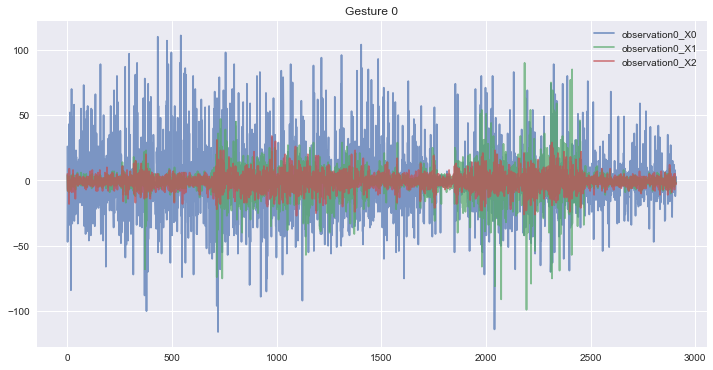

<IPython.core.display.Javascript object>

In [21]:
# A look at how the signals vary over time
gesture_data[gesture_data.target_gesture == 0][features[0:3]].compute().plot(
    alpha=0.7, figsize=(12, 6)
)
plt.title(f"Gesture {0}")
plt.show()



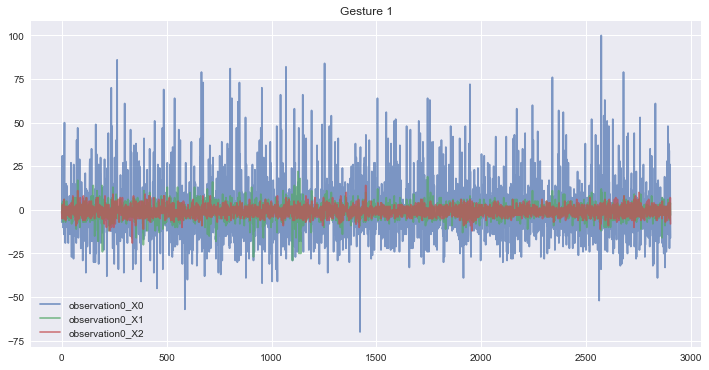

<IPython.core.display.Javascript object>

In [22]:
gesture_data[gesture_data.target_gesture == 1][features[0:3]].compute().plot(
    alpha=0.7, figsize=(12, 6)
)
plt.title(f"Gesture {1}")
plt.show()

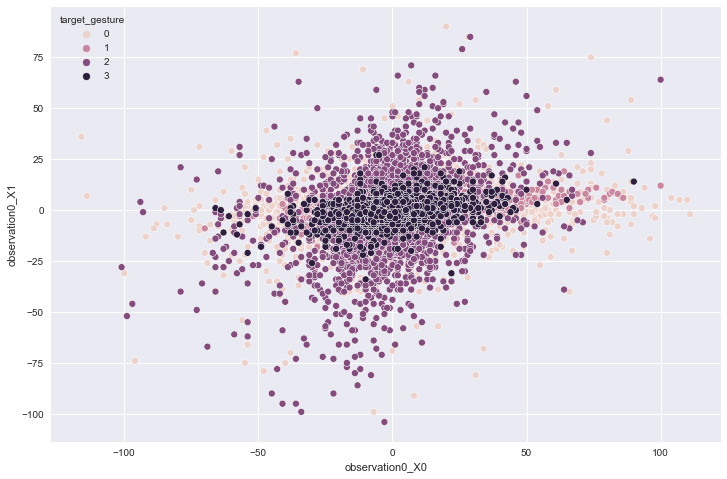

<IPython.core.display.Javascript object>

In [23]:
# a look at some plots of 2 of the sensors plotted agaist each other with colors showing
# the different classes
plt.figure(figsize=[12, 8])
sns.scatterplot(
    data=gesture_data.compute(),
    x="observation0_X0",
    y="observation0_X1",
    hue="target_gesture",
)
plt.show()

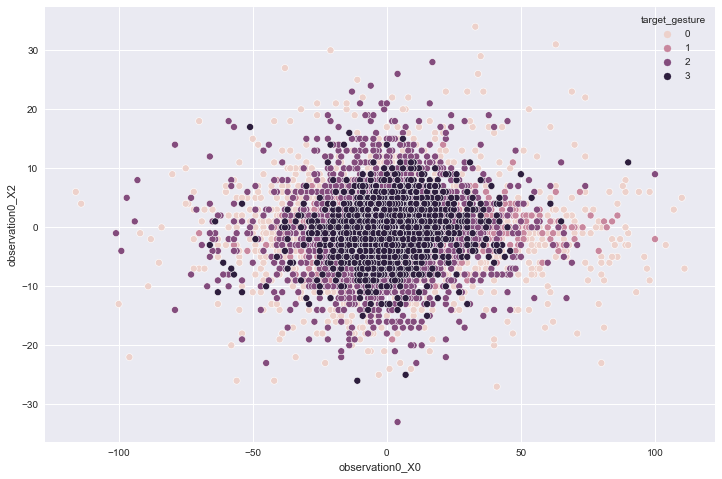

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=[12, 8])
sns.scatterplot(
    data=gesture_data.compute(),
    x="observation0_X0",
    y="observation0_X2",
    hue="target_gesture",
)
plt.show()

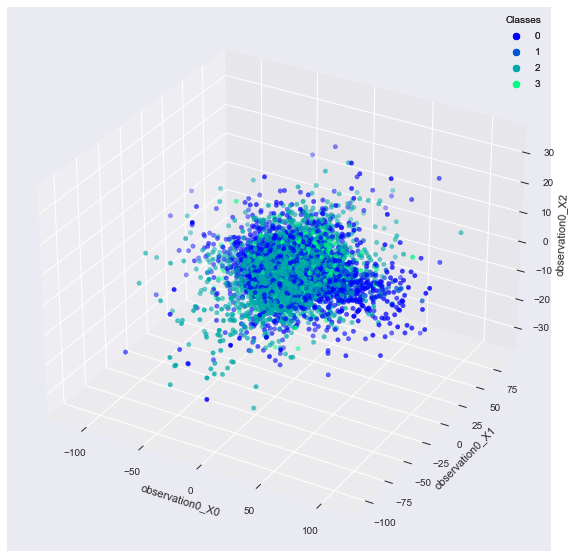

<IPython.core.display.Javascript object>

In [25]:
# and a similar plot for 3 of the sensors
fig = plt.figure(figsize=[13, 10])
ax = fig.gca(projection="3d")
scatter = ax.scatter(
    xs=gesture_data["observation0_X0"].compute(),
    ys=gesture_data["observation0_X1"].compute(),
    zs=gesture_data["observation0_X2"].compute(),
    c=gesture_data["target_gesture"].compute(),
    cmap="winter",
)

legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
ax.set_xlabel("observation0_X0")
ax.set_ylabel("observation0_X1")
ax.set_zlabel("observation0_X2")
plt.show()

### Modeling 
Since our objective is to correctly classify as many of the gestures as possible we will use macro average recall score as our evauation metric

notes
for grig search use `scoring='recall_macro'`
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

for single model scoring use `recall_score(average='macro')`

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score


In [26]:
from dask_ml.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dask_ml.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [27]:
# split the data into train and test sets
X = gesture_data[features]
y = gesture_data.target_gesture
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

<IPython.core.display.Javascript object>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
Test report
---------------------


/Users/abilenky/miniconda3/envs/testenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.05      0.09       596
           1       0.25      1.00      0.39       583
           2       0.00      0.00      0.00       622
           3       0.00      0.00      0.00       604

    accuracy                           0.25      2405
   macro avg       0.30      0.26      0.12      2405
weighted avg       0.30      0.25      0.12      2405

Train macro average recall 0.2610198789974071
Test macro average recall 0.2613255033557047
Genreaization error:  -0.00030562435829761814


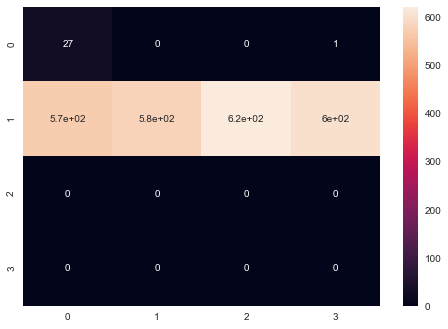

<IPython.core.display.Javascript object>

In [29]:
# I don't expect a logistic regression model to work well but I'm going to try it
# for a baseline of what I expect the worse case to look like
from dask_ml.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    plot_confusion_matrix,
    confusion_matrix,
    recall_score,
)

logit = LogisticRegression()
# Use a pipline to apply a standard scaler to the data
scale = StandardScaler()

pipe = make_pipeline(scale, logit)

pipe.fit(X_train.values.compute(), y_train.values.compute())
# I'll be scoring a bunch of models so I'm creating report function to print a
# summary for each model
def model_report(model):

    y_pred_train = model.predict(X_train.values.compute())
    y_pred_test = model.predict(X_test.values.compute())

    train_score = recall_score(y_train.values.compute(), y_pred_train, average="macro")
    test_score = recall_score(y_test.values.compute(), y_pred_test, average="macro")

    print(model)

    print("Test report")
    print("---------------------")
    print(classification_report(y_test, y_pred_test))
    print(
        f"Train macro average recall {train_score}\n"
        f"Test macro average recall {test_score}\n"
        f"Genreaization error:  {train_score - test_score}"
    )

    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_pred_test, y_test.values.compute())
    )
    sns.heatmap(confusion_matrix_df, annot=True)


model_report(pipe)

In [30]:
# It looks like the logistic regression model is underfitting the data
# Lets try some other models

<IPython.core.display.Javascript object>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Test report
---------------------
              precision    recall  f1-score   support

           0       0.95      0.64      0.76       596
           1       0.54      0.94      0.69       583
           2       0.80      0.34      0.48       622
           3       0.63      0.76      0.69       604

    accuracy                           0.67      2405
   macro avg       0.73      0.67      0.66      2405
weighted avg       0.73      0.67      0.65      2405

Train macro average recall 0.7618432227870829
Test macro average recall 0.6699510882265989
Genreaization error:  0.09189213456048406


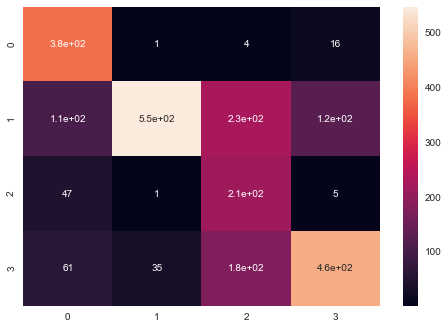

<IPython.core.display.Javascript object>

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pipe = make_pipeline(scale, knn)

with joblib.parallel_backend("dask"):
    pipe.fit(X_train, y_train)
model_report(pipe)

In [32]:
# The KNN model performed much better than the logistic regression model but lets see if
# we can do better

<IPython.core.display.Javascript object>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=20))])
Test report
---------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       596
           1       0.95      0.90      0.92       583
           2       0.90      0.94      0.92       622
           3       0.88      0.87      0.87       604

    accuracy                           0.92      2405
   macro avg       0.92      0.92      0.92      2405
weighted avg       0.92      0.92      0.92      2405

Train macro average recall 0.98738683964583
Test macro average recall 0.9150197005159182
Genreaization error:  0.07236713912991177


,Importance
observation5_X6,0.074560
observation0_X6,0.070629
observation4_X6,0.067594
observation2_X6,0.065998
observation7_X6,0.065525
observation3_X6,0.062129
observation1_X6,0.059792
observation6_X6,0.057825
observation6_X1,0.035712
observation4_X1,0.035193


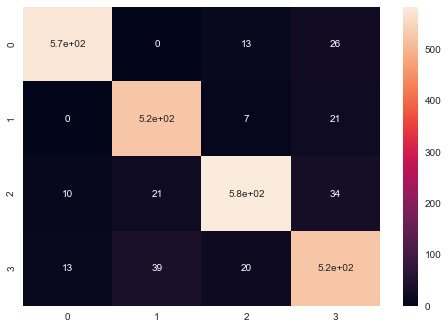

<IPython.core.display.Javascript object>

In [33]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(min_samples_split=20)


pipe = make_pipeline(scale, rfc)

with joblib.parallel_backend("dask"):
    pipe.fit(X_train, y_train)
model_report(pipe)

pd.DataFrame(
    pipe[-1].feature_importances_, index=X_train.columns, columns=["Importance"]
).sort_values("Importance", ascending=False).head(10)

In [34]:
# Over 0.90 for the test set with the random forrest model looks very promising
# looking at the feature importance in the randomforest model it looks like all the
# most important information is coming from one sensor, X6.
# lets try a few more models

<IPython.core.display.Javascript object>

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])
Test report
---------------------
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       596
           1       0.87      0.99      0.92       583
           2       0.93      0.85      0.89       622
           3       0.85      0.87      0.86       604

    accuracy                           0.90      2405
   macro avg       0.90      0.90      0.90      2405
weighted avg       0.90      0.90      0.90      2405

Train macro average recall 0.9519107370688966
Test macro average recall 0.9012940744630122
Genreaization error:  0.05061666260588438


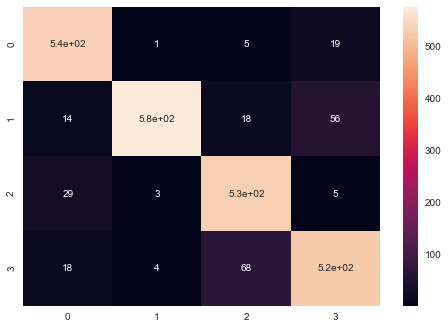

<IPython.core.display.Javascript object>

In [35]:
from sklearn.svm import SVC

svc = SVC()

pipe = make_pipeline(scale, svc)
with joblib.parallel_backend("dask"):
    pipe.fit(X_train, y_train)
model_report(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(min_samples_split=20))])
Test report
---------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       596
           1       0.94      0.97      0.96       583
           2       0.94      0.94      0.94       622
           3       0.91      0.91      0.91       604

    accuracy                           0.94      2405
   macro avg       0.94      0.94      0.94      2405
weighted avg       0.94      0.94      0.94      2405

Train macro average recall 0.975208108289263
Test macro average recall 0.9433694937828264
Genreaization error:  0.03183861450643655


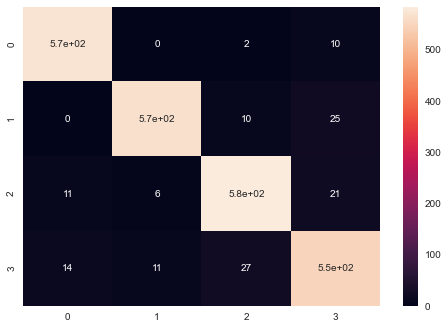

<IPython.core.display.Javascript object>

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(min_samples_split=20)

pipe = make_pipeline(scale, gbc)

with joblib.parallel_backend("dask"):
    pipe.fit(X_train, y_train)
model_report(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.2, n_estimators=1000))])
Test report
---------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       596
           1       0.85      0.94      0.89       583
           2       0.91      0.91      0.91       622
           3       0.84      0.84      0.84       604

    accuracy                           0.89      2405
   macro avg       0.90      0.89      0.89      2405
weighted avg       0.90      0.89      0.89      2405

Train macro average recall 0.902720029372605
Test macro average recall 0.8925042806585883
Genreaization error:  0.010215748714016648


,Importance
observation7_X6,0.076
observation4_X6,0.074
observation6_X6,0.072
observation1_X6,0.071
observation0_X6,0.069
...,...
observation2_X2,0.000
observation1_X2,0.000
observation1_X0,0.000
observation0_X7,0.000


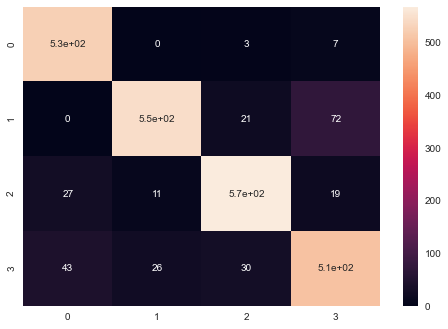

<IPython.core.display.Javascript object>

In [48]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(learning_rate=0.2, n_estimators=1000)

pipe = make_pipeline(scale, abc)

with joblib.parallel_backend("dask"):
    pipe.fit(X_train, y_train)

model_report(pipe)

pd.DataFrame(
    pipe[-1].feature_importances_, index=X_train.columns, columns=["Importance"]
).sort_values("Importance", ascending=False)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=2, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='approx',
                               validate_parameters=1, verbosity=None))])
Test

<AxesSubplot:>

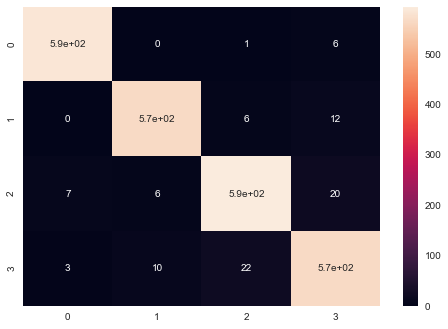

<IPython.core.display.Javascript object>

In [121]:
from dask_ml.xgboost import XGBClassifier as dxgb

xgbc = dxgb()

pipe = make_pipeline(scale, xgbc)
pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train).compute()
y_pred_test = pipe.predict(X_test).compute()



train_score = recall_score(
    y_train.values.compute(), y_pred_train, average="macro"
)
test_score = recall_score(
    y_test.values.compute(), y_pred_test, average="macro"
)

print(pipe)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)


###  Parameter Tuning
The XGBoost model had the best macro average recal score out of all the models I tested so I selected that as the model I will try to improve. It's possibly the XGBoost model just has better default settings but I don't have time to tune every model for this project so I just went with the one with the best initial score. The challence will be whether the score of 0.96 for the test set can be imporved on. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)
Test report
---------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       596
           1       0.97      0.97      0.97       583
           2       0.95      0.95      0.95       622
           3       0.94      0.94      0.94       604

    accuracy                           0.96      2405
   macro av

<AxesSubplot:>

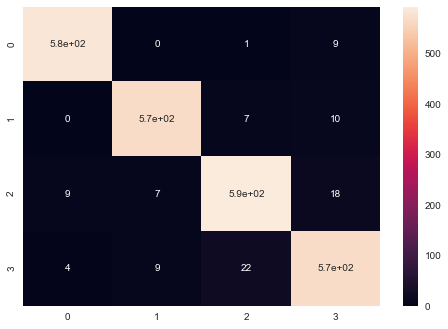

<IPython.core.display.Javascript object>

In [122]:
# lets see if we can reduce overfitting by implementing early stopping
xgbc = dxgb(n_estimators=1000)
xgbc.fit(X_train.values, y_train.values, early_stopping_rounds=25, 
         eval_set=[(X_test.values.compute(), y_test.values.compute())])


y_pred_train = xgbc.predict(X_train.values).compute()
y_pred_test = xgbc.predict(X_test.values).compute()



train_score = recall_score(
    y_train.values.compute(), y_pred_train, average="macro"
)
test_score = recall_score(
    y_test.values.compute(), y_pred_test, average="macro"
)

print(xgbc)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)


In [123]:
# We will use the best value from early stopping for future models
n_trees = xgbc.best_ntree_limit
n_trees

151

<IPython.core.display.Javascript object>

In [124]:
from sklearn.model_selection import GridSearchCV
from dask_ml.preprocessing import MinMaxScaler
# dask_ml xgboost did not seem to work with GridSearch so we'll use the stadard version
from xgboost import XGBClassifier

# the first thing I wanted to check was wether scaling the data had an effect on the accuracy
# so I did grid search to compare a standard scaler min-max scaler and an unscaled version
xgbc = XGBClassifier(n_estimators=n_trees)
scale = StandardScaler()

pipe = Pipeline([("scale", scale), ("clf", xgbc)])

param_grid = {"scale": ["passthrough", StandardScaler(), MinMaxScaler()]}
print(param_grid)

grid = GridSearchCV(
    pipe, param_grid, cv=3, scoring="recall_macro", return_train_score=True
)

with joblib.parallel_backend("dask"):
    grid.fit(X_train.compute(), y_train.compute())



{'scale': ['passthrough', StandardScaler(), MinMaxScaler()]}


/Users/abilenky/miniconda3/envs/testenv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                   

<AxesSubplot:>

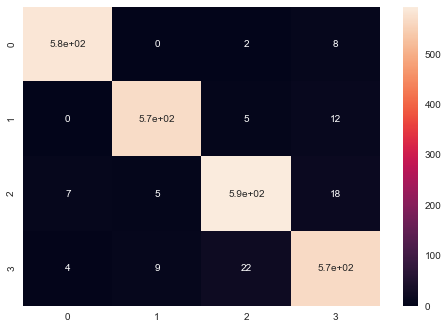

<IPython.core.display.Javascript object>

In [125]:
y_pred_train = grid.predict(X_train.compute())
y_pred_test = grid.predict(X_test.compute())

train_score = recall_score(y_train.compute(), y_pred_train, average="macro")
test_score = recall_score(y_test.compute(), y_pred_test, average="macro")

print(grid)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)

In [126]:
grid.best_params_

{'scale': 'passthrough'}

<IPython.core.display.Javascript object>

In [127]:
# Based on the grid search it looks like scaling was not necessary so we will
# skip it going forward

<IPython.core.display.Javascript object>

In [128]:
grid.cv_results_

{'mean_fit_time': array([33.04873443, 34.88686474, 33.03299888]),
 'std_fit_time': array([0.20708279, 2.22266465, 0.20272711]),
 'mean_score_time': array([0.05833729, 0.03083293, 0.04967014]),
 'std_score_time': array([0.02685723, 0.0085173 , 0.01117135]),
 'param_scale': masked_array(data=['passthrough', StandardScaler(), MinMaxScaler()],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'scale': 'passthrough'},
  {'scale': StandardScaler()},
  {'scale': MinMaxScaler()}],
 'split0_test_score': array([0.95341684, 0.95341684, 0.95341684]),
 'split1_test_score': array([0.95634266, 0.95634266, 0.95634266]),
 'split2_test_score': array([0.96411343, 0.96411343, 0.96411343]),
 'mean_test_score': array([0.95795764, 0.95795764, 0.95795764]),
 'std_test_score': array([0.00451371, 0.00451371, 0.00451371]),
 'rank_test_score': array([1, 1, 1], dtype=int32),
 'split0_train_score': array([1.        , 0.26037509, 1.        ]),
 'split1_train_s

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.2min remaining:   26.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.3min finished
/Users/abilenky/miniconda3/envs/testenv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                    

<AxesSubplot:>

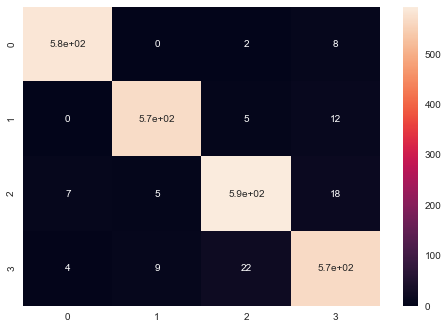

<IPython.core.display.Javascript object>

In [132]:
# lest try varying gamma which controlls the minimum loss reduction required
# to make a further partition on a leaf node of the tree. Default value is 0
# mabe this will help with overfitting.


xgbc = XGBClassifier(n_estimators=n_trees)

param_grid = {"gamma": [0, 0.01, 0.1, 0.5]}

grid = GridSearchCV(
    xgbc,
    param_grid,
    cv=3,
    scoring="recall_macro",
    return_train_score=True,
    n_jobs=-1,
    verbose=True,
)
with joblib.parallel_backend("dask"):
    grid.fit(X_train.compute(), y_train.compute())

y_pred_train = grid.predict(X_train.compute())
y_pred_test = grid.predict(X_test.compute())

train_score = recall_score(y_train.compute(), y_pred_train, average="macro")
test_score = recall_score(y_test.compute(), y_pred_test, average="macro")

print(grid)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)

In [133]:
grid.best_params_

{'gamma': 0}

<IPython.core.display.Javascript object>

In [134]:
best_gamma = grid.best_params_["gamma"]

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.3min finished
/Users/abilenky/miniconda3/envs/testenv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:47:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_

<AxesSubplot:>

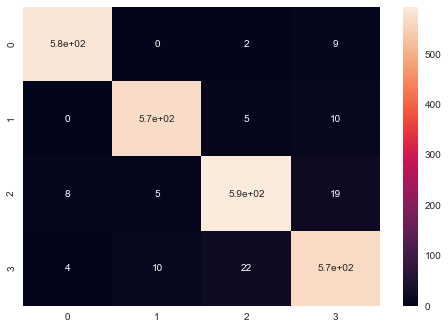

<IPython.core.display.Javascript object>

In [135]:
# lets try varying the amount of l2 regularization
xgbc = XGBClassifier(n_estimators=n_trees, gamma=best_gamma)

param_grid = {"reg_lambda": [0.01, 0.1, 1, 10, 20, 50]}

grid = GridSearchCV(
    xgbc,
    param_grid,
    cv=3,
    scoring="recall_macro",
    return_train_score=True,
    n_jobs=-1,
    verbose=True,
)

with joblib.parallel_backend("dask"):
    grid.fit(X_train.compute(), y_train.compute())

y_pred_train = grid.predict(X_train.compute())
y_pred_test = grid.predict(X_test.compute())

train_score = recall_score(y_train.compute(), y_pred_train, average="macro")
test_score = recall_score(y_test.compute(), y_pred_test, average="macro")

print(grid)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)

In [136]:
print(grid.best_params_)


{'reg_lambda': 0.1}


<IPython.core.display.Javascript object>

In [137]:
best_lambda = grid.best_params_["reg_lambda"]

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished
/Users/abilenky/miniconda3/envs/testenv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_

<AxesSubplot:>

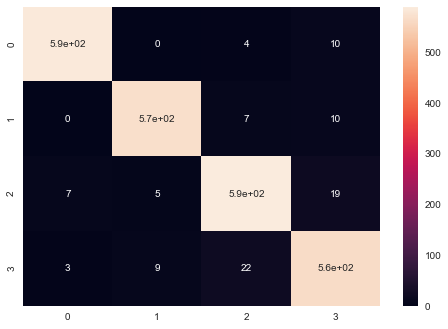

<IPython.core.display.Javascript object>

In [138]:
# lets try changing the max depth of the trees (default: 6)
xgbc = XGBClassifier(n_estimators=n_trees, gamma=best_gamma, reg_lambda=best_lambda)

param_grid = {"max_depth": [2, 4, 6, 8, 10]}

grid = GridSearchCV(
    xgbc,
    param_grid,
    cv=3,
    scoring="recall_macro",
    return_train_score=True,
    n_jobs=-1,
    verbose=True,
)

with joblib.parallel_backend("dask"):
    grid.fit(X_train.compute(), y_train.compute())

y_pred_train = grid.predict(X_train.compute())
y_pred_test = grid.predict(X_test.compute())

train_score = recall_score(y_train.compute(), y_pred_train, average="macro")
test_score = recall_score(y_test.compute(), y_pred_test, average="macro")

print(grid)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)

In [139]:
print(grid.best_params_)

{'max_depth': 8}


<IPython.core.display.Javascript object>

In [141]:
best_max_depth = grid.best_params_["max_depth"]
best_max_depth

8

<IPython.core.display.Javascript object>

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=151, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=None, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)
Test report
---------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       596
           1       0.97      0.97      0.97       583
           2       0.95      0.95      0.95       622
           3       0.94      0.94      0.94       604

    accuracy                           0.96      2405
   macro a

<AxesSubplot:>

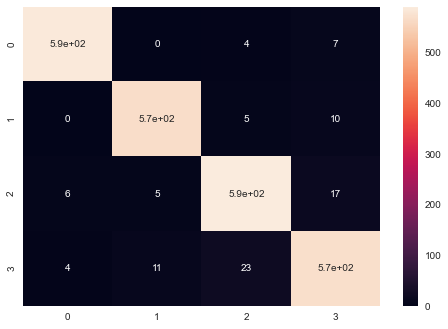

<IPython.core.display.Javascript object>

In [143]:
# Lets take a look at our final model 
# We can use the dask version for this since we are done with gridSearch
xgbc = dxgb(
    n_estimators=n_trees,
    gamma=best_gamma,
    reg_lambda=best_lambda,
    max_depth=best_max_depth,
)
xgbc.fit(X_train, y_train)

y_pred_train = xgbc.predict(X_train).compute()
y_pred_test = xgbc.predict(X_test).compute()


train_score = recall_score(y_train.values.compute(), y_pred_train, average="macro")
test_score = recall_score(y_test.values.compute(), y_pred_test, average="macro")

print(xgbc)

print("Test report")
print("---------------------")
print(classification_report(y_test.values.compute(), y_pred_test))
print(
    f"Train macro average recall {train_score}\n"
    f"Test macro average recall {test_score}\n"
    f"Genreaization error:  {train_score - test_score}"
)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_pred_test, y_test.values.compute())
)
sns.heatmap(confusion_matrix_df, annot=True)

In [145]:
# make sure to close the dask client
client.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


<IPython.core.display.Javascript object>

In [146]:
# Note on the comments on the parameters, they can change if the train test split is rerun.

<IPython.core.display.Javascript object>

# Conclusions and next steps
There are more parameters that I didn't have enought time to tune but I was able to imporve the macro average recall for the test set from 0.96 to 0.962
Another things I'd like to do if I had more time is try out a model with a subset of features. Sensor X6 consistenly came up in the top of the feature importance list so it would be interesting to try a model with just the top ten most important features.

If I had acess to a Myo armband and a robot arm I would try to implement the rest of the control system. 